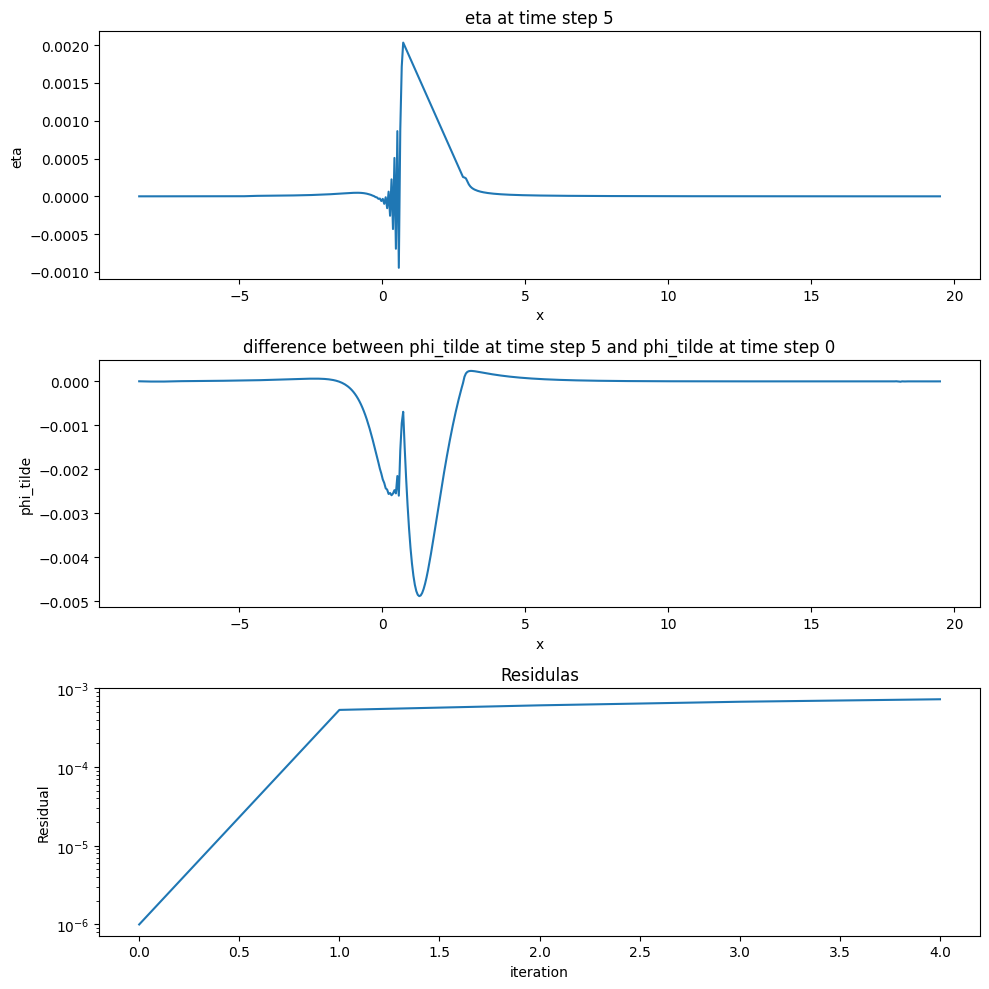

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

eta = np.load("./arrays/eta.npy")
phi = np.load("./arrays/phiTilde.npy")
fs_xs = np.load("./arrays/coordsFS.npy")

# sorter informationen i alle numpy arrays
idx = np.argsort(fs_xs, axis=1)
eta = np.take_along_axis(eta, idx, axis=1)
phi = np.take_along_axis(phi, idx, axis=1)
fs_xs = np.take_along_axis(fs_xs, idx, axis=1)

residuals = np.load("./arrays/residuals.npy")
residuals, time_step = residuals[:,0], residuals[:,1]

fig, ax = plt.subplots(3, 1, figsize = (10,10))
time = np.where(time_step == 0)[0][0] - 1
try:
    time = np.where(time_step == 0)[0][0] - 1
except:
    time = len(time_step) - 1

# time = 1

height_of_FS = eta[0][0]
ax[0].plot(fs_xs[time][:], eta[time][:]-height_of_FS)
if time - 50 > 0:
    ax[0].plot(fs_xs[time-10][:], eta[time-10][:] - 1, alpha = 0.7, linestyle = "--")
    ax[0].plot(fs_xs[time-50][:], eta[time-50][:] - 1, alpha = 0.5, linestyle = "--")

ax[0].set_title(f"eta at time step {time}" )
ax[0].set_xlabel("x")
ax[0].set_ylabel("eta")

init_phi = phi[0]
ax[1].plot(fs_xs[0], phi[time]-init_phi)
if time - 50 > 0:
    ax[1].plot(fs_xs[0], phi[time-10], alpha = 0.7, linestyle = "--")
    ax[1].plot(fs_xs[0], phi[time-50], alpha = 0.5, linestyle = "--")
ax[1].set_title(f"difference between phi_tilde at time step {time} and phi_tilde at time step 0" )
ax[1].set_xlabel("x")
ax[1].set_ylabel("phi_tilde")

ax[2].plot(residuals[:time])
ax[2].set_title("Residulas")
ax[2].set_xlabel("iteration")
ax[2].set_ylabel("Residual")
ax[2].set_yscale("log")

plt.tight_layout()
plt.show()

In [2]:
print(phi[0][0] - phi[0][0])

0.0


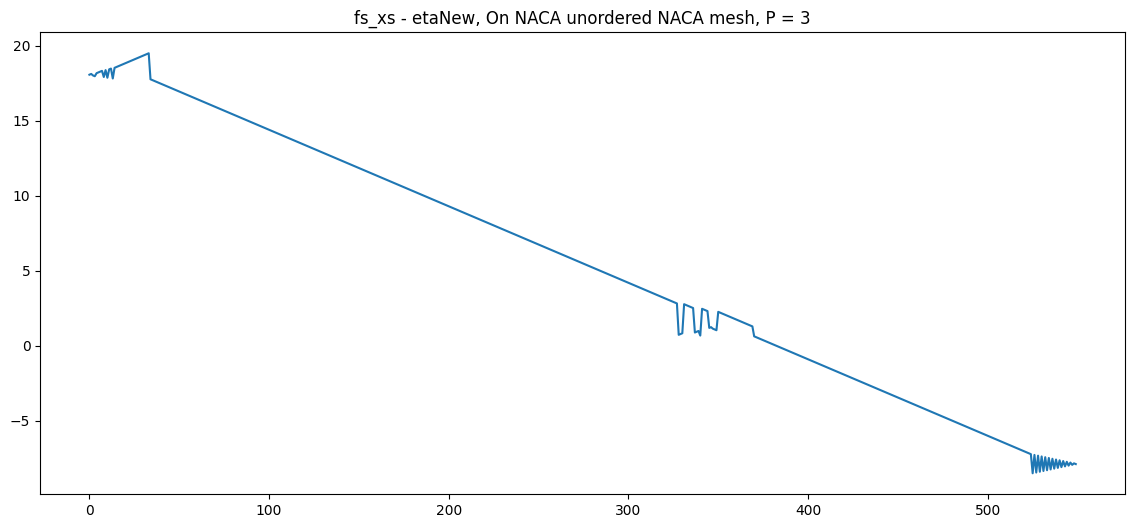

In [3]:
fig, ax = plt.subplots(1, 1, figsize = (14,6))
time = 0
ax.plot(fs_xs[0])
#ax.plot(np.linspace(-8,27, len(fs_xs[time])), np.sin(np.linspace(-8,27, len(fs_xs[time]))), linestyle = "--")
ax.set_title(f"fs_xs - etaNew, On NACA unordered NACA mesh, P = 3")
# ax.set_xlim(5,10)
plt.show()

In [4]:
np.sin(fs_xs[0]/(8+27))

array([ 4.93701816e-01,  4.94968514e-01,  4.92434070e-01,  4.91165279e-01,
        4.96234160e-01,  4.97498753e-01,  4.98762290e-01,  5.00024767e-01,
        4.89895444e-01,  5.01286183e-01,  4.88624569e-01,  5.02546534e-01,
        5.03805818e-01,  4.87352657e-01,  5.05064032e-01,  5.06321174e-01,
        5.07577241e-01,  5.08832230e-01,  5.10086138e-01,  5.11338964e-01,
        5.12590703e-01,  5.13841354e-01,  5.15090914e-01,  5.16339380e-01,
        5.17586750e-01,  5.18833021e-01,  5.20078190e-01,  5.21322255e-01,
        5.22565213e-01,  5.23807061e-01,  5.25047797e-01,  5.26287417e-01,
        5.27525921e-01,  5.28763304e-01,  4.86079710e-01,  4.84805730e-01,
        4.83530722e-01,  4.82254686e-01,  4.80977627e-01,  4.79699546e-01,
        4.78420446e-01,  4.77140331e-01,  4.75859202e-01,  4.74577063e-01,
        4.73293917e-01,  4.72009765e-01,  4.70724611e-01,  4.69438457e-01,
        4.68151307e-01,  4.66863163e-01,  4.65574027e-01,  4.64283903e-01,
        4.62992792e-01,  

import firedrake as fd

P =3
mesh = fd.UnitSquareMesh(100, 100)
V = fd.FunctionSpace(mesh, "CG", P)
V1 = fd.FunctionSpace(mesh, "CG", 1)
fSIndecies = V.boundary_nodes(4)
coordsFS = (fd.Function(fd.VectorFunctionSpace(mesh, "CG", P)).interpolate(mesh.coordinates).dat.data)[fSIndecies,:]
fsMesh = fd.IntervalMesh(len(fSIndecies)-1, 0, 1)
fsMesh.coordinates.dat.data[:] = coordsFS[:,0]

Vfs = fd.FunctionSpace(fsMesh, "CG", 1)
eta = fd.Function(Vfs)
eta.dat.data[:] = coordsFS[:,1]

newEta = fd.Function(Vfs)
newEta.dat.data[:] = np.sin(2*3.14*coordsFS[:,0])

coords = mesh.coordinates.dat.data[:]
M = 0.5
coordsMask = coords[:, 1] > M

eta2d = np.interp(coords[coordsMask,0], fsMesh.coordinates.dat.data[:], eta.dat.data[:])
newEta2d = np.interp(coords[coordsMask,0], fsMesh.coordinates.dat.data[:], newEta.dat.data[:])

coords[coordsMask, 1] = M + (newEta2d - M)/(eta2d - M) * (coords[coordsMask, 1] - M)
mesh.coordinates.dat.data[:] = coords

plt.plot(coordsFS[::3,0], coords[V1.boundary_nodes(4), 1])
